In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [2]:
test_image = cv2.imread("micro_test_files/1745176127617.jpg") 
# camera is upside down by default
test_image = cv2.rotate(test_image, cv2.ROTATE_180)
road_mask = cv2.imread("micro_test_files/road_mask.png")

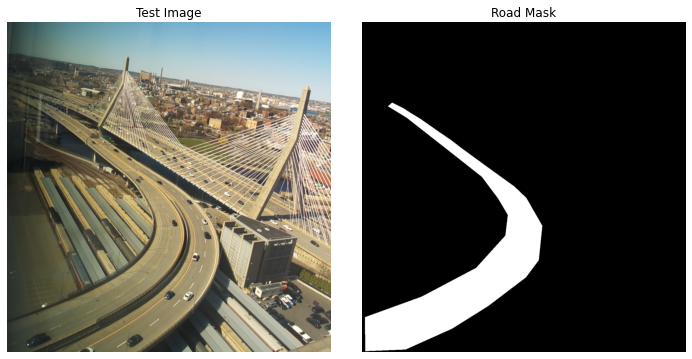

In [3]:
# Plot the test image and the test image and the road mask side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Test Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_mask, cv2.COLOR_BGR2RGB))
plt.title("Road Mask")
plt.axis("off")
plt.tight_layout()
plt.show()
# Save the test image and the road mask to a file

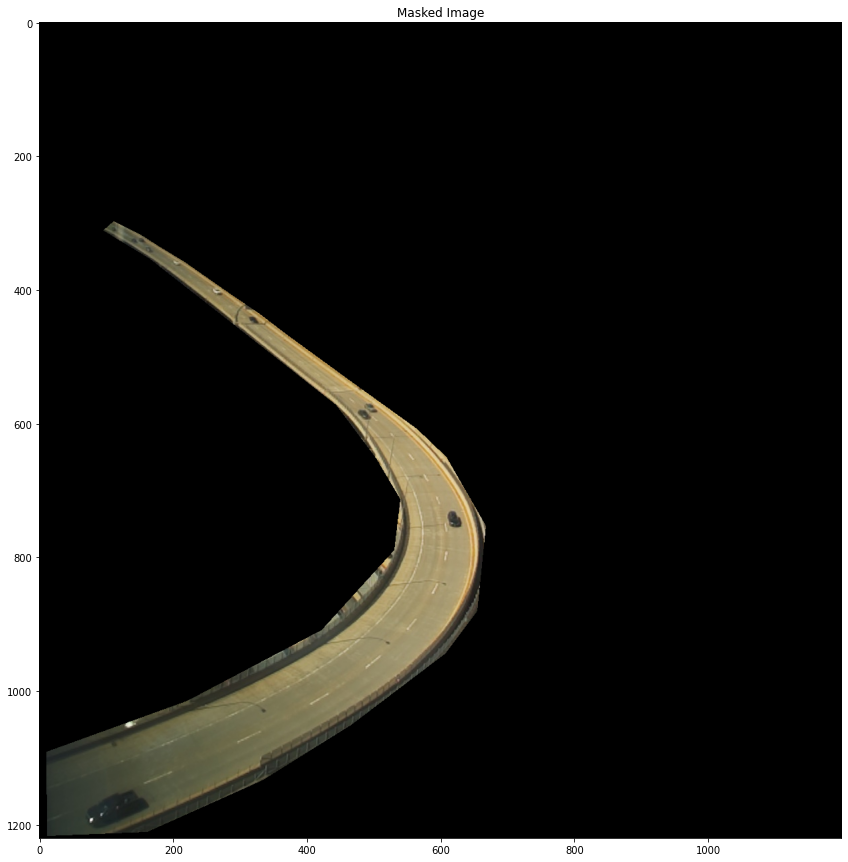

In [121]:
# Mask the test image with the road mask and trim to 200:height, 0:650
h,w = road_mask.shape[:2]
masked_image = cv2.bitwise_and(test_image, road_mask)
#masked_image = masked_image[250:h, 0:650]
# Show the masked image
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image")
#plt.axis("off")
plt.show()

In [5]:
import os
import glob
import cv2
import numpy as np

def compute_median_background(frame_dir: str,
                              pattern: str = "*.*",
                              save_to: str | None = None) -> np.ndarray:
    """
    Build a static‑background estimate by taking the per‑pixel median
    across all frames in `frame_dir`.

    Parameters
    ----------
    frame_dir : str
        Directory containing road frames (e.g. "test_frames/").
    pattern   : str, default "*.*"
        Glob pattern for frame filenames ("*.jpg", "*.png", etc.).
    save_to   : str | None, default None
        If given, the median image is written to this path.

    Returns
    -------
    median_img : np.ndarray (H×W×3, uint8)
        The background image.
    """
    paths = sorted(glob.glob(os.path.join(frame_dir, pattern)))
    if not paths:
        raise FileNotFoundError(f"No images matching {pattern} in {frame_dir}")

    # Stack frames into one big array (N, H, W, C)
    frames = [cv2.imread(p, cv2.IMREAD_COLOR) for p in paths]
    frames = [f for f in frames if f is not None]  # drop unreadables
    median_img = np.median(np.stack(frames, axis=0), axis=0).astype(np.uint8)

    if save_to:
        cv2.imwrite(save_to, median_img)

    return median_img

# Example usage
bg = compute_median_background("test_frames", pattern="*.jpg", save_to="median_bg.jpg")


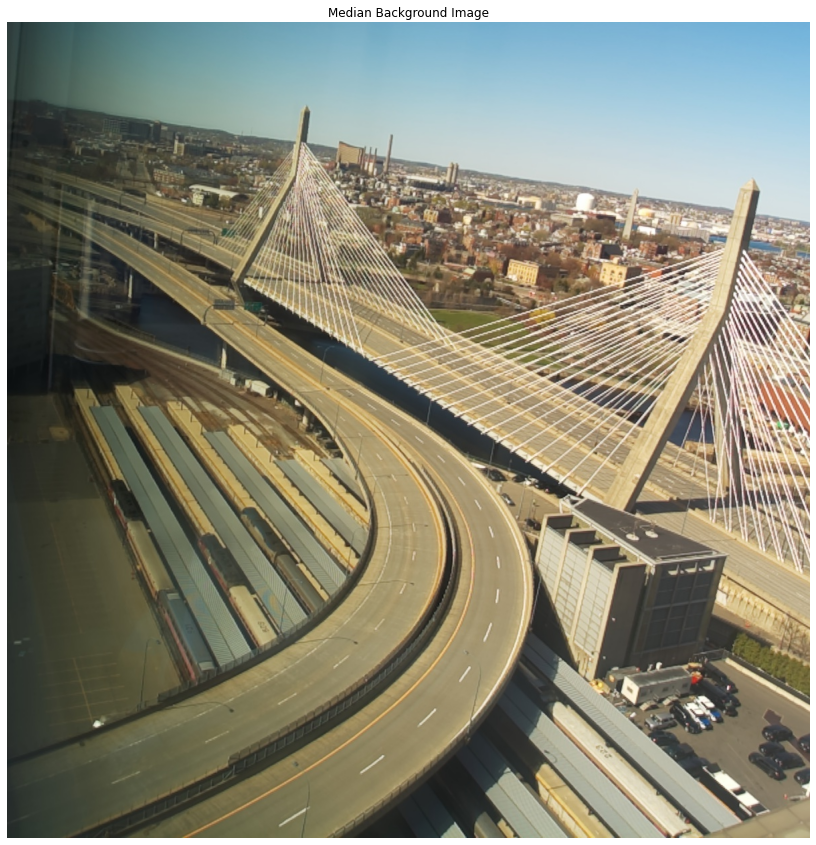

In [6]:
# load the median background image
median_bg = cv2.imread("median_bg.jpg")
# camera is upside down by default
median_bg = cv2.rotate(median_bg, cv2.ROTATE_180)
# Show the median background image
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(median_bg, cv2.COLOR_BGR2RGB))
plt.title("Median Background Image")
plt.axis("off")
plt.show()


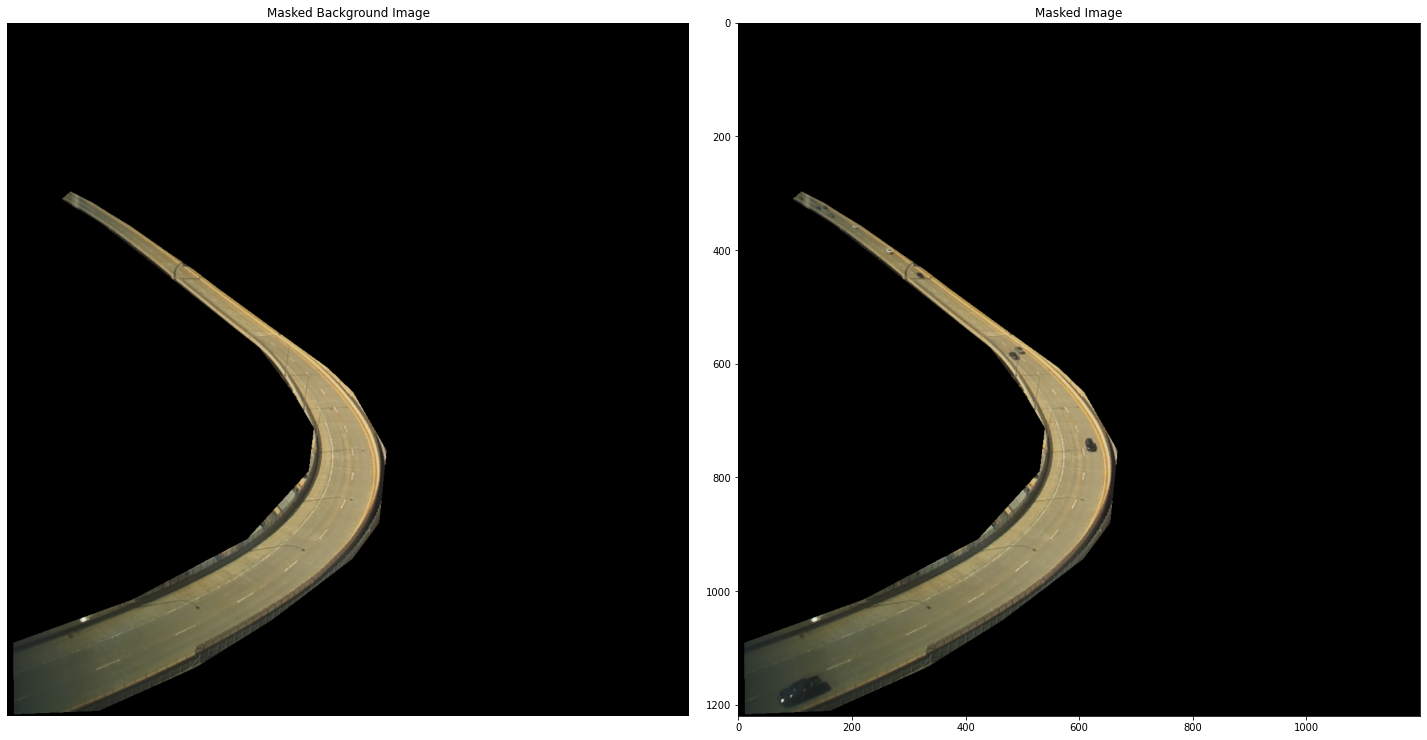

In [122]:
# mask the median background image with the road mask and trim to 200:height, 0:650
h,w = road_mask.shape[:2]
masked_bg = cv2.bitwise_and(median_bg, road_mask)
#masked_bg = masked_bg[250:h, 0:650]
# Show the masked background image and the masked image side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(masked_bg, cv2.COLOR_BGR2RGB))
plt.title("Masked Background Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image")
#plt.axis("off")
plt.tight_layout()
plt.show()


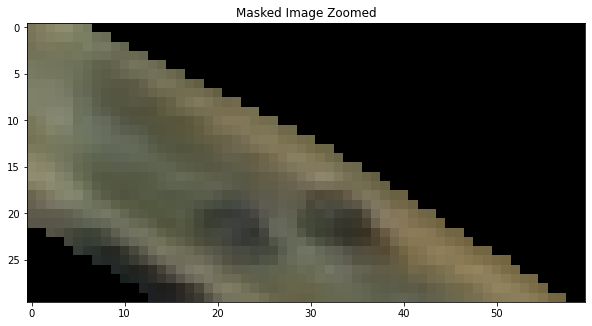

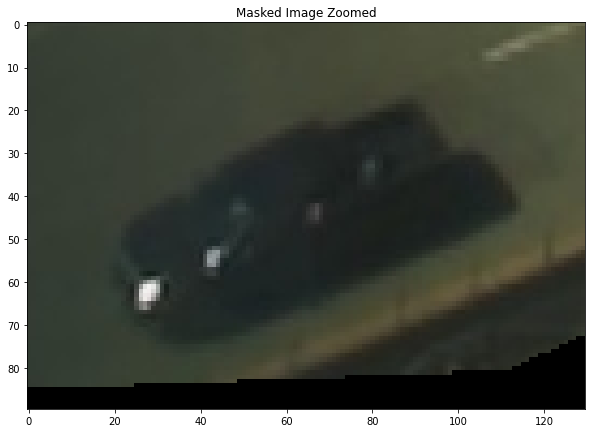

In [23]:
# show the masked image over the range 0:255
masked_image_zoomed_top = masked_image[55:85, 120:180]
masked_image_zoomed_bottom = masked_image[880:980, 50:180]
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(masked_image_zoomed_top, cv2.COLOR_BGR2RGB))
plt.title("Masked Image Zoomed")
#plt.axis("off")
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(masked_image_zoomed_bottom, cv2.COLOR_BGR2RGB))
plt.title("Masked Image Zoomed")
#plt.axis("off")
plt.show()

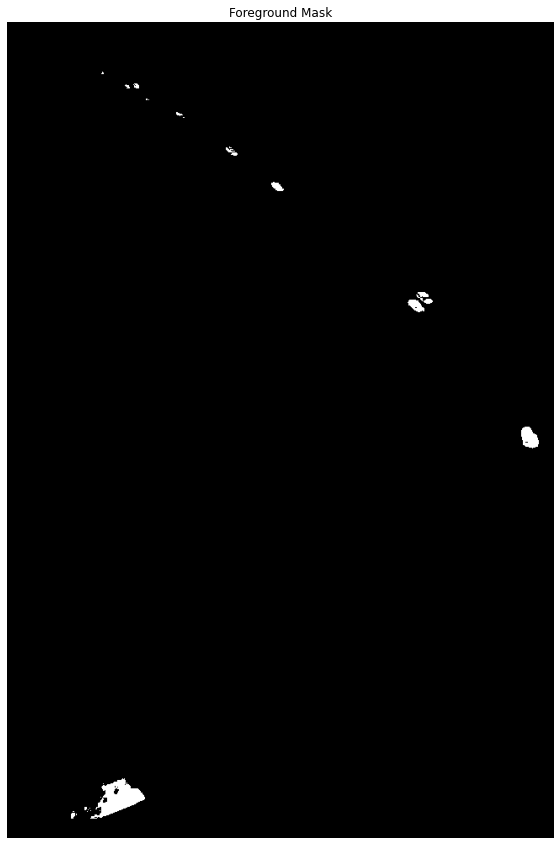

In [8]:
diff = cv2.absdiff(masked_image, masked_bg)
gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
_, fgmask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(fgmask, cv2.COLOR_BGR2RGB))
plt.title("Foreground Mask")
plt.axis("off")
plt.show()


In [91]:
import numpy as np
import cv2
from scipy.interpolate import splprep, splev

def smooth_edges_and_flatten(
    image: np.ndarray,
    left_pts: np.ndarray,    # shape (N,2)
    right_pts: np.ndarray,   # shape (N,2)
    num_samples: int = 800,
    num_t: int = 300,
    spline_s: float = 5.0
):
    """
    1) Fit smoothing splines to each edge
    2) Resample both to uniform parameter u ∈ [0,1]
    3) Compute smooth centerline & widths
    4) Perform curvilinear remap as before
    """
    H, W = image.shape[:2]

    # ——— 1) spline‐fit left & right edges ———
    # pack coords for splprep (expects separate x,y arrays)
    tx, ty = left_pts[:,0],  left_pts[:,1]
    ux, uy = right_pts[:,0], right_pts[:,1]

    # tck and u arrays for each edge
    tck_L, u_L = splprep([tx, ty], s=spline_s, k=3)
    tck_R, u_R = splprep([ux, uy], s=spline_s, k=3)

    # uniform parameter
    u_f = np.linspace(0, 1, num_samples)

    # evaluate smoothed edge curves
    xL_s, yL_s = splev(u_f, tck_L)
    xR_s, yR_s = splev(u_f, tck_R)
    left_s   = np.vstack((xL_s, yL_s)).T
    right_s  = np.vstack((xR_s, yR_s)).T

    # ——— 2) derive smooth centerline & widths ———
    center   = (left_s + right_s) / 2.0
    widths   = np.linalg.norm(right_s - left_s, axis=1) / 2.0  # half‐width

    # ——— 3) compute unit normals (for curvilinear warp) ———
    dx = np.gradient(center[:,0])
    dy = np.gradient(center[:,1])
    mag = np.hypot(dx, dy)
    nx, ny = -dy/mag, dx/mag

    # ——— 4) build map_x/map_y and remap ———
    t_norm = np.linspace(-1, 1, num_t)
    map_x  = np.zeros((num_samples, num_t), dtype=np.float32)
    map_y  = np.zeros((num_samples, num_t), dtype=np.float32)

    for i in range(num_samples):
        for j in range(num_t):
            off = t_norm[j] * widths[i]
            map_x[i,j] = center[i,0] + off * nx[i]
            map_y[i,j] = center[i,1] + off * ny[i]

    warped = cv2.remap(
        image, map_x, map_y,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )
    return warped, map_x, map_y


In [24]:
import numpy as np
import cv2

def compute_arclength(pts):
    """Return 1D array s of cumulative arc‐length along the Nx2 array pts."""
    d = np.diff(pts, axis=0)
    ds = np.hypot(d[:,0], d[:,1])
    return np.concatenate(([0.], np.cumsum(ds)))

def road_flatten(
    image: np.ndarray,
    centerline_pts: list[tuple[float,float]],
    widths_at_pts: list[float],
    num_s: int = 800,
    num_t: int = 300
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    image         : H×W×3 frame
    centerline_pts: list of (x,y) along the road from near→far
    widths_at_pts : full road width (in pixels) at each centerline point
    num_s         : samples along the road
    num_t         : samples across the width

    returns (warped, map_x, map_y)
    """
    H, W = image.shape[:2]
    pts    = np.array(centerline_pts, dtype=np.float32)
    widths = np.array(widths_at_pts,  dtype=np.float32)

    # 1) parameterize centerline by arc‐length s
    s_orig    = compute_arclength(pts)
    s_uniform = np.linspace(0, s_orig[-1], num_s)

    # 2) resample centerline coords & widths on uniform s
    x_u = np.interp(s_uniform, s_orig, pts[:,0])
    y_u = np.interp(s_uniform, s_orig, pts[:,1])
    w_u = np.interp(s_uniform, s_orig, widths) / 2.0   # half‐width per sample

    # 3) compute tangents & normals
    tx = np.gradient(x_u)
    ty = np.gradient(y_u)
    mag = np.hypot(tx, ty)
    nx = -ty / mag    # normal x
    ny =  tx / mag    # normal y

    # 4) build map_x/map_y
    t_norm = np.linspace(-1, 1, num_t)  # lateral fraction from left→right
    map_x  = np.zeros((num_s, num_t), dtype=np.float32)
    map_y  = np.zeros((num_s, num_t), dtype=np.float32)

    for i in range(num_s):
        for j in range(num_t):
            offset = t_norm[j] * w_u[i]
            map_x[i, j] = x_u[i] + offset * nx[i]
            map_y[i, j] = y_u[i] + offset * ny[i]

    # 5) remap
    warped = cv2.remap(
        image, map_x, map_y,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )
    return warped, map_x, map_y


In [106]:
import cv2, csv, os

# ————— CONFIG —————
IMAGE_PATH = "median_bg.jpg"
OUTPUT_CSV = "road_edges.csv"
# ——————————————————

img = cv2.imread(IMAGE_PATH)
# camera is upside down by default
img = cv2.rotate(img, cv2.ROTATE_180)
if img is None: raise FileNotFoundError(IMAGE_PATH)
disp = img.copy()

left_pts, right_pts = [], []
mode = "left"   # start in left‐edge mode

def on_mouse(evt, x, y, *args):
    global left_pts, right_pts
    if evt == cv2.EVENT_LBUTTONDOWN:
        if mode == "left":
            left_pts.append((x, y))
            cv2.circle(disp, (x,y), 4, (0,0,255), -1)
        else:
            right_pts.append((x, y))
            cv2.circle(disp, (x,y), 4, (255,0,0), -1)
        cv2.imshow("Annotate Edges", disp)

cv2.namedWindow("Annotate Edges")
cv2.setMouseCallback("Annotate Edges", on_mouse)

print("Press 'l' for LEFT edge, 'r' for RIGHT edge, 's' to save & exit.")

while True:
    cv2.imshow("Annotate Edges", disp)
    key = cv2.waitKey(0) & 0xFF
    if key == ord('l'):
        mode = "left"
        print("MODE → LEFT edge")
    elif key == ord('r'):
        mode = "right"
        print("MODE → RIGHT edge")
    elif key == ord('s'):
        # Save CSV with: x_left, y_left, x_right, y_right
        # If the two lists have different lengths, pad the shorter with its last point.
        N = max(len(left_pts), len(right_pts))
        L = left_pts + [left_pts[-1]]*(N - len(left_pts))
        R = right_pts + [right_pts[-1]]*(N - len(right_pts))
        with open(OUTPUT_CSV, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["x_left","y_left","x_right","y_right"])
            for (xl,yl),(xr,yr) in zip(L,R):
                w.writerow([xl,yl,xr,yr])
        print(f"Saved {N} edge pairs to {OUTPUT_CSV}")
        break
    elif key == 27:  # ESC to quit without saving
        print("Aborted, no file saved.")
        break

cv2.destroyAllWindows()



Press 'l' for LEFT edge, 'r' for RIGHT edge, 's' to save & exit.
MODE → LEFT edge
MODE → RIGHT edge
Saved 13 edge pairs to road_edges.csv


In [82]:
import csv
import numpy as np

# 1) Load edge points
left_pts, right_pts = [], []
with open("road_edges.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        left_pts.append((float(row["x_left"]), float(row["y_left"])))
        right_pts.append((float(row["x_right"]), float(row["y_right"])))

left = np.array(left_pts)
right = np.array(right_pts)

# 2) Compute centerline & widths
center = (left + right) / 2.0           # midpoints
widths = np.linalg.norm(right - left, axis=1)

# 3) (Optional) Resample to uniform arc‐length if you need
#    so your road_flatten() gets evenly‐spaced samples:
def resample_by_arclength(pts, num=500):
    # pts: Nx2 array
    ds = np.hypot(*(np.diff(pts, axis=0).T))
    s  = np.concatenate(([0], np.cumsum(ds)))
    s_u = np.linspace(0, s[-1], num)
    x_u = np.interp(s_u, s, pts[:,0])
    y_u = np.interp(s_u, s, pts[:,1])
    return np.vstack((x_u,y_u)).T

N = 800
center_u = resample_by_arclength(center, num=N)
widths_u = np.interp(
    np.linspace(0,1,N),
    np.linspace(0,1,len(widths)),
    widths
)

# Now feed `center_u.tolist()` and `widths_u.tolist()` into your road_flatten()


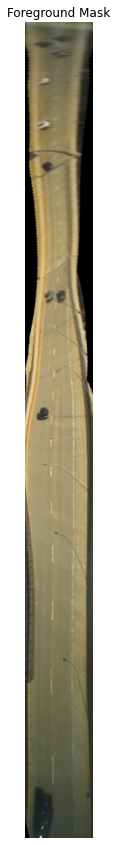

In [127]:
test_flat_frame = masked_bg.copy()
# camera is upside down by default
#test_flat_frame = cv2.rotate(test_flat_frame, cv2.ROTATE_180)

# 1) Load edge points
left_pts, right_pts = [], []
with open("road_edges.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        left_pts.append((float(row["x_left"]), float(row["y_left"])))
        right_pts.append((float(row["x_right"]), float(row["y_right"])))

left = np.array(left_pts)
right = np.array(right_pts)

# reformate left points to be np.ndarray,    # shape (N,2)
left_pts = np.array(left_pts, dtype=np.float32)
right_pts = np.array(right_pts, dtype=np.float32)


warped_masked_bg, map_x, map_y = smooth_edges_and_flatten(
    masked_bg,
    left_pts=left_pts,
    right_pts=right_pts,
    num_samples=1200,  # number of samples along the road
    num_t=100,       # number of samples across the road
    spline_s=0.1     # smoothing factor for the splines
)

warped_masked_image, map_x, map_y = smooth_edges_and_flatten(
    masked_image,
    left_pts=left_pts,
    right_pts=right_pts,
    num_samples=1200,  # number of samples along the road
    num_t=100,       # number of samples across the road
    spline_s=0.1     # smoothing factor for the splines
)
# rotate warped image by 90 degrees
#warped_mask = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Save the warped image
# Show the warped image
diff = cv2.absdiff(warped_masked_image, warped_masked_bg)
gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
_, warped_fgmask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(warped_masked_image, cv2.COLOR_BGR2RGB))
plt.title("Foreground Mask")
plt.axis("off")
plt.show()




In [ ]:

paths = sorted(glob.glob(os.path.join("test_frames/", "*.jpg")))

# Stack frames into one big array (N, H, W, C)
frames = [cv2.imread(p, cv2.IMREAD_COLOR) for p in paths]
# get first 10 frames
#frames = frames[:10]

# save 
# warp each frame
warped_frames = []
for frame in frames:
    # camera is upside down by default
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    warped_frame, map_x, map_y = smooth_edges_and_flatten(
        frame,
        left_pts=left_pts,
        right_pts=right_pts,
        num_samples=1200,  # number of samples along the road
        num_t=200,       # number of samples across the road
        spline_s=20.0     # smoothing factor for the splines
    )
    warped_frames.append(warped_frame)

# make warped_frames dir
if not os.path.exists("warped_frames"):
    os.makedirs("warped_frames")
    
# save out each warped frame
for i, warped_frame in enumerate(warped_frames):
    cv2.imwrite(f"warped_frames/frame_{i}.jpg", warped_frame)
    # Show the warped image


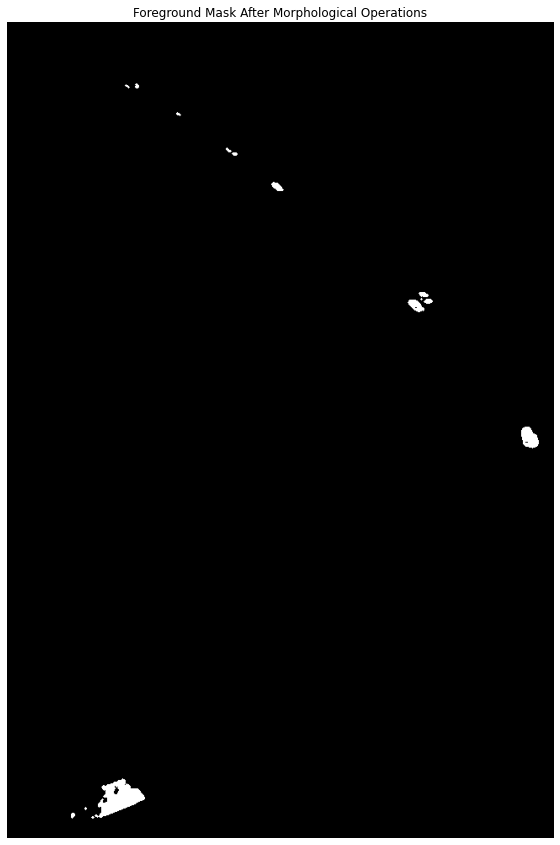

In [13]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
fgmask2 = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel, iterations=1)
#fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel, iterations=2)
# show the foreground mask after morphological operations
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(fgmask2, cv2.COLOR_BGR2RGB))
plt.title("Foreground Mask After Morphological Operations")
plt.axis("off")
plt.show()



In [11]:
MIN_AREA = 4
output_image = masked_image.copy()
contours, _ = cv2.findContours(fgmask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if cv2.contourArea(cnt) < MIN_AREA:  # filter tiny noise
        continue
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(output_image, (x,y), (x+w,y+h), (0,255,0), 2)


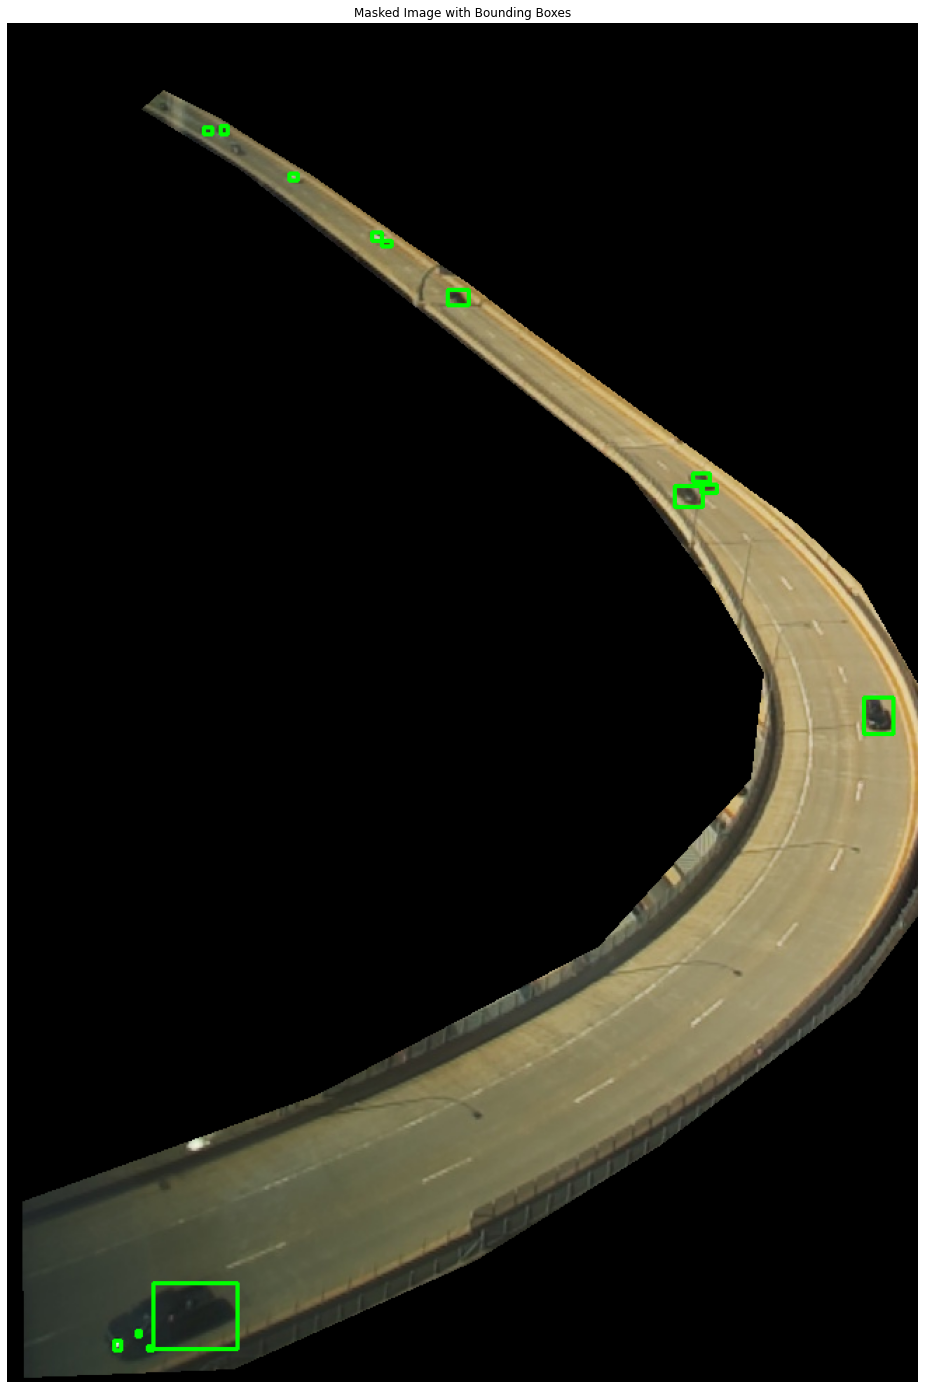

In [12]:
# show the masked image with the bounding boxes
plt.figure(figsize=(25, 25))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image with Bounding Boxes")
plt.axis("off")
plt.show()
